In [ ]:
### Harishankar M

### Reference of implementation taken from :https://github.com/shivamsaboo17/Overcoming-Catastrophic-forgetting-in-Neural-Networks



# Import necessary libraries
from train import *

# Elastic Weight Consolidation class
class ElasticWeightConsolidation:
    def __init__(self, model, crit, lr=0.001, ewc_weight=10000):
        self.model = model
        self.crit = crit
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        self.ewc_weight = ewc_weight
        self.fisher_information = {}
        self.previous_params = {}

    def compute_fisher(self, data_loader, device):
        """Calculate Fisher Information for each parameter."""
        self.model.train()  # Switch to training mode
        fisher_info = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}

        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            self.model.zero_grad()
            output = self.model(x)
            loss = self.crit(output, y)
            loss.backward()

            for name, param in self.model.named_parameters():
                fisher_info[name] += param.grad.pow(2).detach()

        # Normalize Fisher Information
        for name in fisher_info:
            fisher_info[name] /= len(data_loader.dataset)

        self.model.eval()  # Switch back to evaluation mode
        return fisher_info


    def consolidate(self):
        """Save the previous parameters and Fisher Information."""
        self.previous_params = {name: param.clone().detach() for name, param in self.model.named_parameters()}
        self.fisher_information = self.compute_fisher(self.data_loader, self.device)

    def penalty(self):
        """Calculate the EWC penalty based on Fisher Information."""
        penalty = 0
        for name, param in self.model.named_parameters():
            prev_param = self.previous_params[name]
            fisher = self.fisher_information[name]
            penalty += (fisher * (param - prev_param).pow(2)).sum()
        return penalty

    def train_epoch(self, data_loader, device):
        """Train the model with EWC regularization."""
        self.model.train()
        total_loss = 0

        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            self.optimizer.zero_grad()
            output = self.model(x)
            loss = self.crit(output, y)

            if self.previous_params:  # Apply EWC penalty if previous params exist
                loss += self.ewc_weight * self.penalty()

            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()

        return total_loss / len(data_loader)


   
def train_and_evaluate(model, ewc, X_train, y_train, X_val, y_val, X_test, y_test, device, epochs=100, batch_size=32):
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    ewc.data_loader = train_loader
    ewc.device = device

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        train_loss = ewc.train_epoch(train_loader, device)
        train_losses.append(train_loss)

        # Validation phase
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                val_loss += ewc.crit(preds, y).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Evaluate the model
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            predictions.append(preds.cpu().numpy())
            actuals.append(y.cpu().numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    return predictions, actuals, train_losses, val_losses

# Plot results



[*********************100%***********************]  1 of 1 completed


Epoch [1/100], Train Loss: 0.0117, Val Loss: 0.0009
Epoch [2/100], Train Loss: 0.0004, Val Loss: 0.0003
Epoch [3/100], Train Loss: 0.0004, Val Loss: 0.0004
Epoch [4/100], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [5/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [6/100], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [7/100], Train Loss: 0.0002, Val Loss: 0.0005
Epoch [8/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [9/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [10/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [11/100], Train Loss: 0.0002, Val Loss: 0.0006
Epoch [12/100], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [13/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/100], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [15/100], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [16/100], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [17/100], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [18/100], Train Loss: 0.0001, Val Loss: 0.0006
Epoch [19/100], Train Loss: 0.0001, Val Loss: 0.0001
Ep

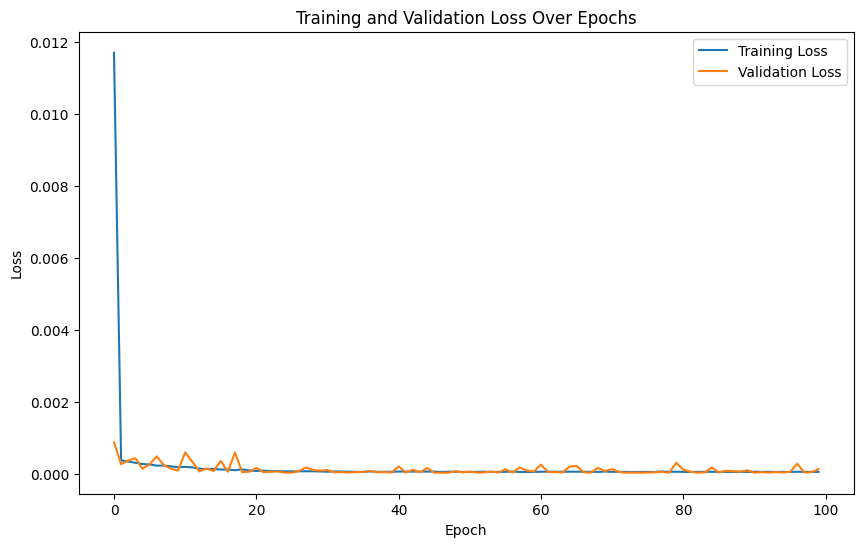

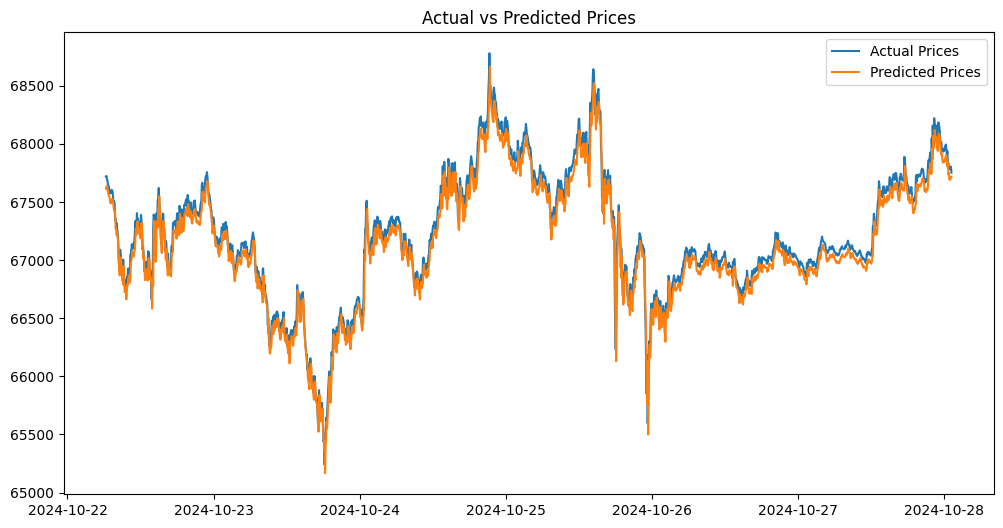

R² Score: 0.9627


[*********************100%***********************]  1 of 1 completed


### Dataset Summary ###
Training Samples: 1758
Validation Samples: 195
Testing Samples: 803
Total Samples: 2756
Test Set Start Date: 2024-11-04 05:05:00+00:00
Test Set End Date: 2024-11-06 23:55:00+00:00
#######################
Epoch [1/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [2/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [3/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [4/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [5/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [6/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [7/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [8/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [9/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [10/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [11/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [12/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/100], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [14/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [15/100], Train Loss: 0.0002, Val

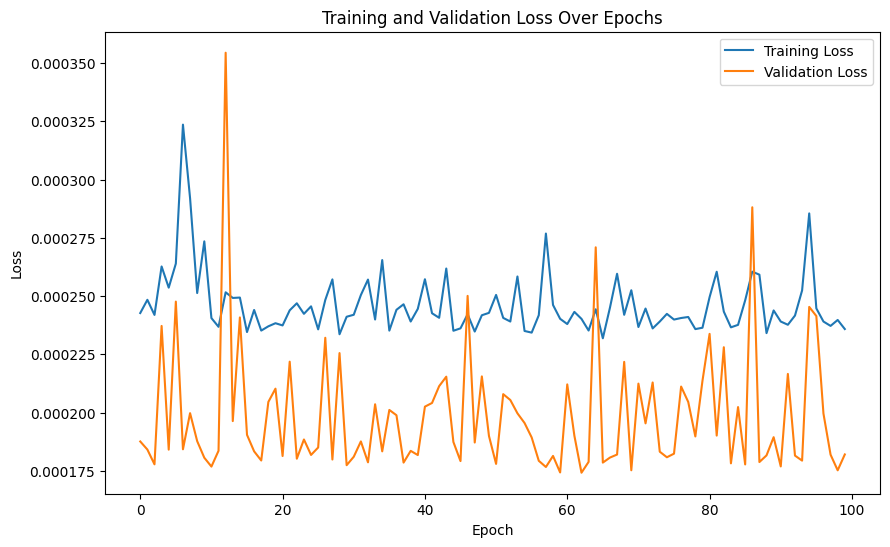

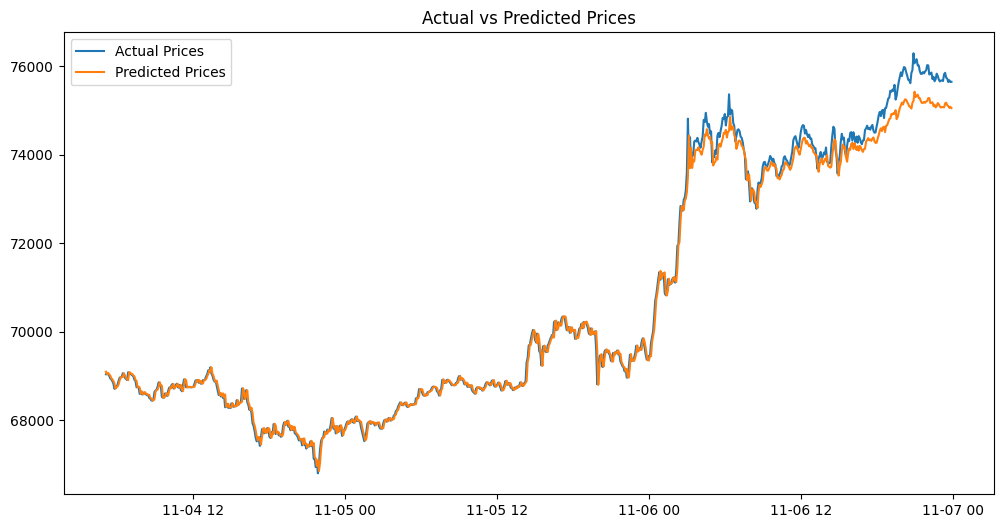

[*********************100%***********************]  1 of 1 completed

R² Score: 0.9923




### Dataset Summary ###
Training Samples: 1760
Validation Samples: 195
Testing Samples: 804
Total Samples: 2759
Test Set Start Date: 2024-11-14 04:55:00+00:00
Test Set End Date: 2024-11-16 23:55:00+00:00
#######################
Epoch [1/100], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [2/100], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [3/100], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [4/100], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [5/100], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [6/100], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [7/100], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [8/100], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [9/100], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [10/100], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [11/100], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [12/100], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [13/100], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [14/100], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [15/100], Train Loss: 0.0001, Val

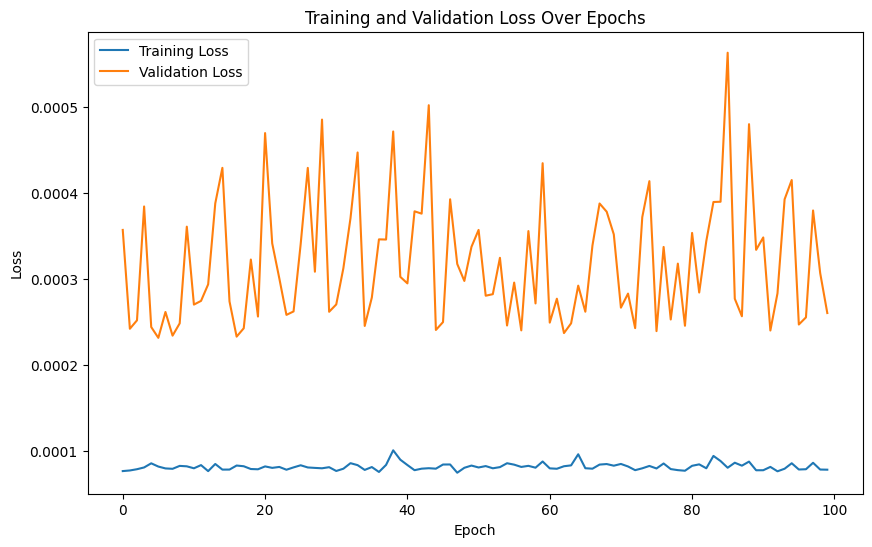

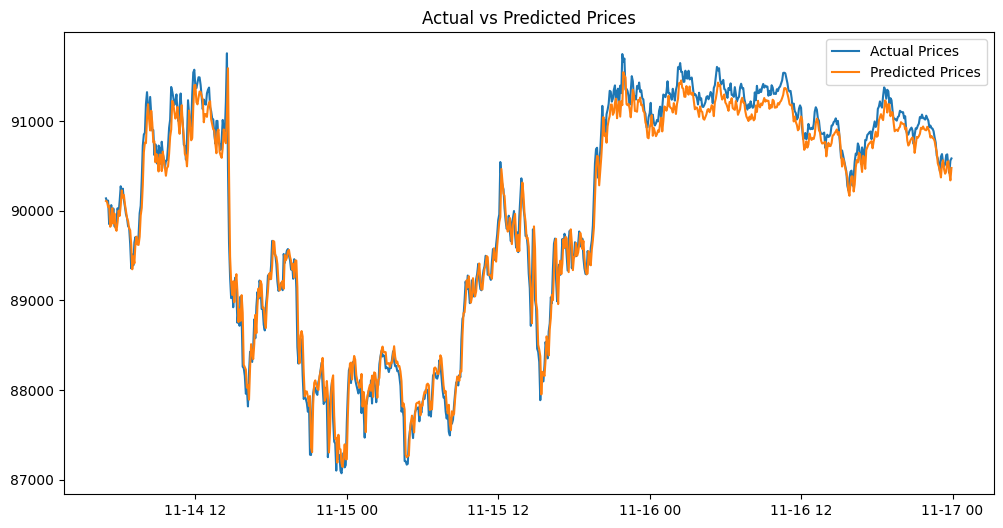

R² Score: 0.9793




[*********************100%***********************]  1 of 1 completed


### Dataset Summary ###
Training Samples: 1729
Validation Samples: 192
Testing Samples: 790
Total Samples: 2711
Test Set Start Date: 2024-11-24 02:05:00+00:00
Test Set End Date: 2024-11-26 19:50:00+00:00
#######################
Epoch [1/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [2/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [3/100], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [4/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [5/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [6/100], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [7/100], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [8/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [9/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [10/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [11/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [12/100], Train Loss: 0.0002, Val Loss: 0.0006
Epoch [13/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/100], Train Loss: 0.0002, Val Loss: 0.0007
Epoch [15/100], Train Loss: 0.0003, Val

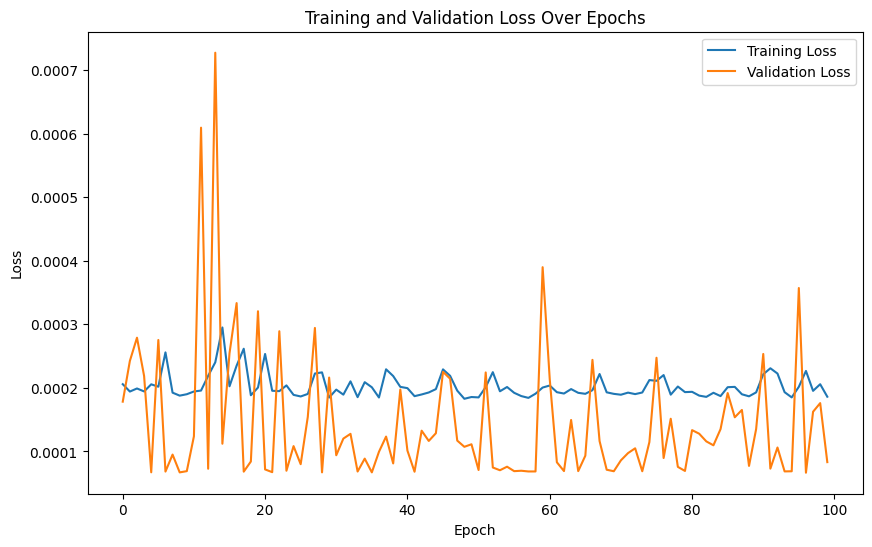

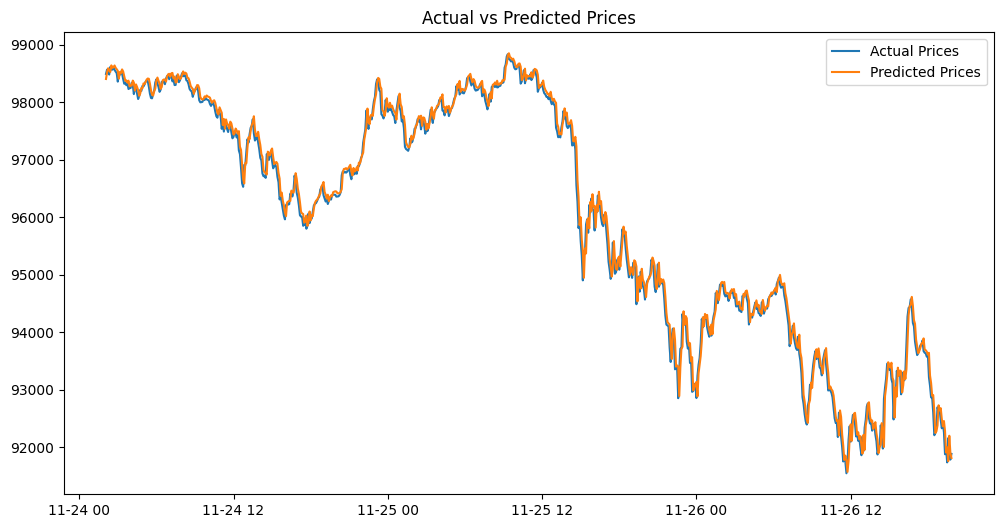

R² Score: 0.9930




In [2]:

ticker_label = "BTC-USD"
sequence_length = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TODAY = datetime.datetime.now()

START = TODAY - datetime.timedelta(days=60)  # Last 60 days

# Initial task
start1, end1 = START, START +datetime.timedelta(days=30)

# Define model and EWC
input_size, hidden_size, num_layers, output_size = 1, 64, 2, 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
ewc = ElasticWeightConsolidation(model, criterion, lr=0.001, ewc_weight=10000)


dataset_initial,scaler,test_dates = dataset_extraction(stock=ticker_label,start_time=start1,stop_time=end1, sequence_length=60,)
X_train = dataset_initial['train'] 
X_val = dataset_initial['val'] 
X_test = dataset_initial['test'] 

y_train = dataset_initial['train_label'] 
y_val = dataset_initial['val_label'] 
y_test =dataset_initial['test_label']

X_train, y_train = X_train.to(device), y_train.to(device)

predictions, actuals, train_losses, val_losses = train_and_evaluate(model, ewc, X_train, y_train, X_val, y_val, X_test, y_test, device)

predictions = scaler.inverse_transform( predictions)
actuals = scaler.inverse_transform( actuals)

plot_loss(train_losses, val_losses)
plot_results(actuals, predictions, test_dates)

r2 = calculate_r2(actuals, predictions)
print(f"R² Score: {r2:.4f}")


data_periods = []

data_periods.append((str_date(START +datetime.timedelta(days=30) ),str_date(START +datetime.timedelta(days=40) )))
data_periods.append((str_date(START +datetime.timedelta(days=40) ),str_date(START +datetime.timedelta(days=50) )))
data_periods.append((str_date(START +datetime.timedelta(days=50) ),str_date(START +datetime.timedelta(days=60) )))
# Incremental tasks
for (start, end) in data_periods:
    dataset_initial,scaler,test_dates = dataset_extraction(stock=ticker_label,start_time=start,stop_time=end, sequence_length=60,train_ratio=0.7,val_ratio = 0.1)
    train_count, val_count, test_count, total_count, start_test_date, end_test_date = dataset_summary(dataset_initial, test_dates)  
    X_train = dataset_initial['train'] 
    X_val = dataset_initial['val'] 
    X_test = dataset_initial['test'] 

    y_train = dataset_initial['train_label'] 
    y_val = dataset_initial['val_label'] 
    y_test =dataset_initial['test_label']
    X_train, y_train = X_train.to(device), y_train.to(device)
    ewc.consolidate()
    predictions, actuals, train_losses, val_losses = train_and_evaluate(model, ewc, X_train, y_train, X_val, y_val, X_test, y_test, device)

    predictions = scaler.inverse_transform( predictions)
    actuals = scaler.inverse_transform( actuals)

    plot_loss(train_losses, val_losses)
    plot_results(actuals, predictions, test_dates)

    r2 = calculate_r2(actuals, predictions)
    print(f"R² Score: {r2:.4f}")
    print('\n')
    
